In [1]:
# import display libs
from IPython.display import Image
%matplotlib inline
from IPython.display import Latex

In [2]:
# import libs
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt


# setup figure params
figureparams = {'axes.labelsize': 24,
           'axes.titlesize': 20,
           'axes.linewidth': 1.3,
           'font.size': 20,
           'legend.fontsize': 18,
           'figure.figsize': (10,7),
           'font.family': 'serif',
           'font.serif': 'Computer Modern Roman',
           'xtick.labelsize': 18,
           'xtick.major.size': 5.5,
           'xtick.major.width': 1.3,
           'ytick.labelsize': 18,
           'ytick.major.size': 5.5,
           'ytick.major.width': 1.3,
           'text.usetex': True,
           'figure.autolayout': True}
plt.rcParams.update(figureparams)
matplotlib.rcParams['text.usetex']=False
matplotlib.rcParams['text.latex.unicode']=True
matplotlib.get_configdir()

C:\Users\EdwardJansenADC\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.


'C:\\Users\\EdwardJansenADC\\.matplotlib'

# ARIMA

In [3]:
# Import additional libs
import warnings
import itertools
import statsmodels.api as sm

### Load Data

In [4]:
# Load the data
df = pd.read_csv('avocado.csv')
cols = df.columns

In [5]:
df.region.unique()

array(['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'California', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork',
       'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia',
       'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland',
       'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento',
       'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',
       'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse',
       'Tampa', 'TotalUS', 'West', 'WestTexNewMexico'], dtype=object)

#### Select Timeseries

In [6]:
region = 'TotalUS'
Type = 'conventional'

In [133]:
df_sub = df.loc[ (df.region == region) & (df.type == Type)]

# keep only price and dates
keepcols = ['Date', 'AveragePrice']
ts = df_sub[keepcols].sort_values('Date')
ts['Date']=pd.to_datetime(ts['Date'], format='%Y-%m-%d')


ts.index = ts.Date
ts = ts.drop(['Date'], axis=1)

In [134]:
ts = ts.resample('2W').mean()

In [135]:
ts

,AveragePrice
Date,
2015-01-04,0.950
2015-01-18,1.020
2015-02-01,0.965
2015-02-15,0.990
2015-03-01,0.995
...,...
2018-01-28,1.085
2018-02-11,0.920
2018-02-25,1.070


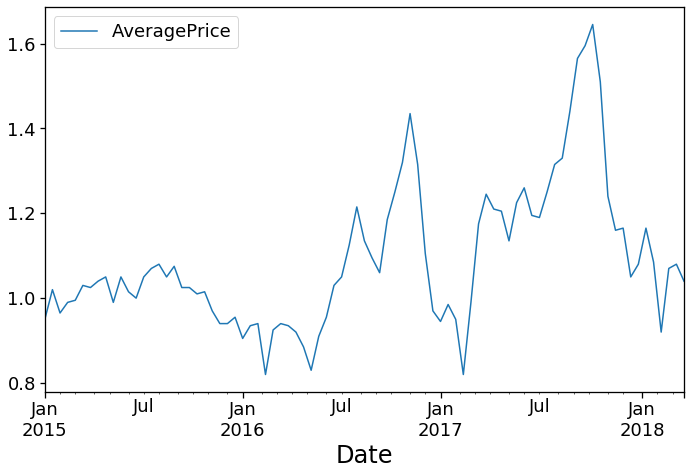

In [136]:
ts.plot()

In [19]:
ts.Date.tail(14)

8320    2017-12-24
8319    2017-12-31
9101    2018-01-07
9100    2018-01-14
9099    2018-01-21
9098    2018-01-28
9097    2018-02-04
9096    2018-02-11
9095    2018-02-18
9094    2018-02-25
9093    2018-03-04
9092    2018-03-11
9091    2018-03-18
9090    2018-03-25
Name: Date, dtype: object

In [156]:
train_data = ts.loc[(ts.index >= '2016-01-03') & (ts.index <='2017-12-01')]
test_data = ts.loc[(ts.index >= '2017-12-01') & (ts.index <='2018-03-25')]

In [157]:
train_data

,AveragePrice
Date,
2016-01-03,0.905
2016-01-17,0.935
2016-01-31,0.940
2016-02-14,0.820
2016-02-28,0.925
2016-03-13,0.940
2016-03-27,0.935
2016-04-10,0.920
2016-04-24,0.885


## ARIMA fit

In [158]:
# fit model
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=(3,1,0),
                                seasonal_order=(1,1,0,24),
                                enforce_stationarity=False,
                                enforce_invertibility=False ) 

results = mod.fit()

IndexError: index 0 is out of bounds for axis 0 with size 0

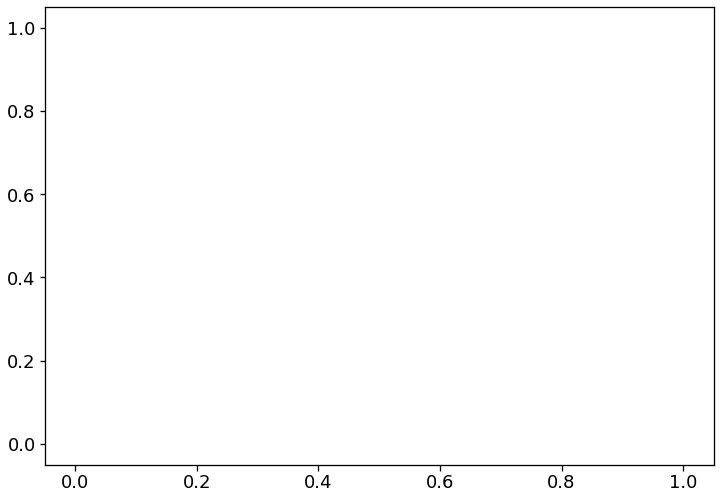

In [159]:
results.plot_diagnostics(figsize=(20, 14))
plt.show()

## Results

In [160]:
pred0 = results.get_prediction(start='2017-01-01', dynamic=False)
pred0_ci = pred0.conf_int()

pred1 = results.get_prediction(start='2017-01-01', dynamic=True)
pred1_ci = pred1.conf_int()

pred2 = results.get_forecast(26)
pred2_ci = pred2.conf_int()
print(pred2.predicted_mean)

2017-12-03    1.145018
2017-12-17    1.131692
2017-12-31    1.143353
2018-01-14    1.061684
2018-01-28    1.173354
2018-02-11    1.291689
2018-02-25    1.326687
2018-03-11    1.285020
2018-03-25    1.308354
2018-04-08    1.276688
2018-04-22    1.361687
2018-05-06    1.391687
2018-05-20    1.373354
2018-06-03    1.400021
2018-06-17    1.413354
2018-07-01    1.443354
2018-07-15    1.441687
2018-07-29    1.556687
2018-08-12    1.661687
2018-08-26    1.705021
2018-09-09    1.776687
2018-09-23    1.646687
2018-10-07    1.396687
2018-10-21    1.298354
2018-11-04    1.280032
2018-11-18    1.284482
Freq: 2W-SUN, dtype: float64


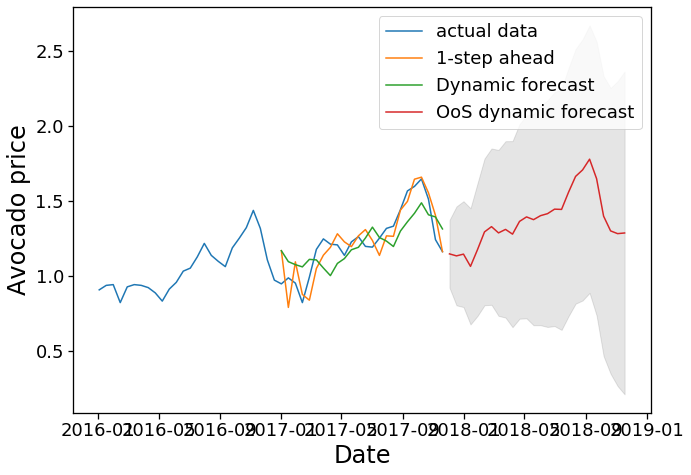

In [161]:
#fig, ax = plt.subplots(figsize=(15,8))
plt.plot(train_data.index, train_data.values, label='actual data')
plt.plot(pred0.predicted_mean.index, pred0.predicted_mean.values, label='1-step ahead')
plt.plot(pred1.predicted_mean.index, pred1.predicted_mean.values, label='Dynamic forecast')
plt.plot(pred2.predicted_mean.index, pred2.predicted_mean.values, label='OoS dynamic forecast')
plt.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('Avocado price')
plt.xlabel('Date')
plt.legend()

In [145]:
pred0.predicted_mean

Date
2017-11-19    1.111071
Freq: 2W-SUN, dtype: float64

<Figure size 720x504 with 0 Axes>

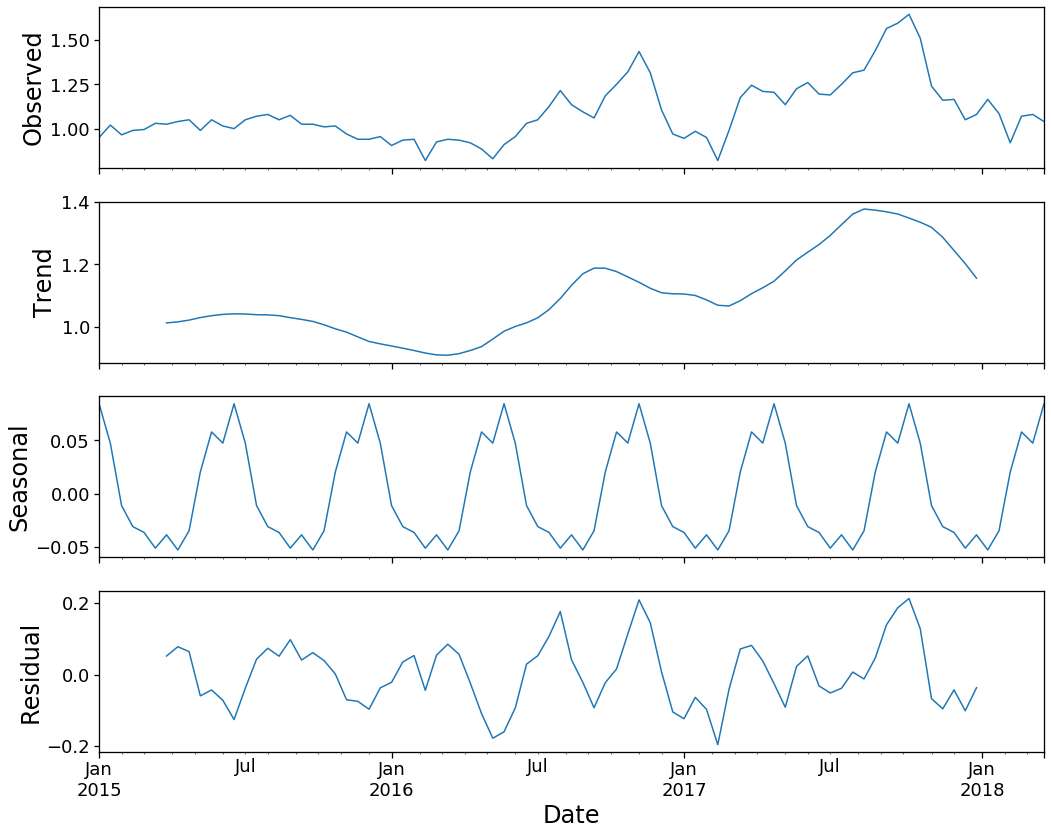

In [170]:
import statsmodels.tsa.seasonal as seas
decomposition = seas.seasonal_decompose(ts.AveragePrice, freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 12)

In [177]:
trend = decomposition.trend
seasonal = decomposition.seasonal trend
residuals = decomposition.residual

AttributeError: 'DecomposeResult' object has no attribute 'residual'

In [178]:
trend

Date
2015-01-04   NaN
2015-01-18   NaN
2015-02-01   NaN
2015-02-15   NaN
2015-03-01   NaN
              ..
2018-01-28   NaN
2018-02-11   NaN
2018-02-25   NaN
2018-03-11   NaN
2018-03-25   NaN
Freq: 2W-SUN, Name: AveragePrice, Length: 85, dtype: float64